**Retail Customer Inventory Turnover**
- Analyze average throughput rate and average inventory of customers from purchase order data
- Compare with Little's Law calculations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read the CSV file
file = pd.read_csv("Rogers_022824.csv", parse_dates=['purchase_datetime']) #assuming jupyter notebook file is in the same directory as the csv file

**Part 1**: Plot how many customers entered the store in every 15 minutes from 7AM-11:00PM. Then, calculate how many customers entered the store per hour on average.

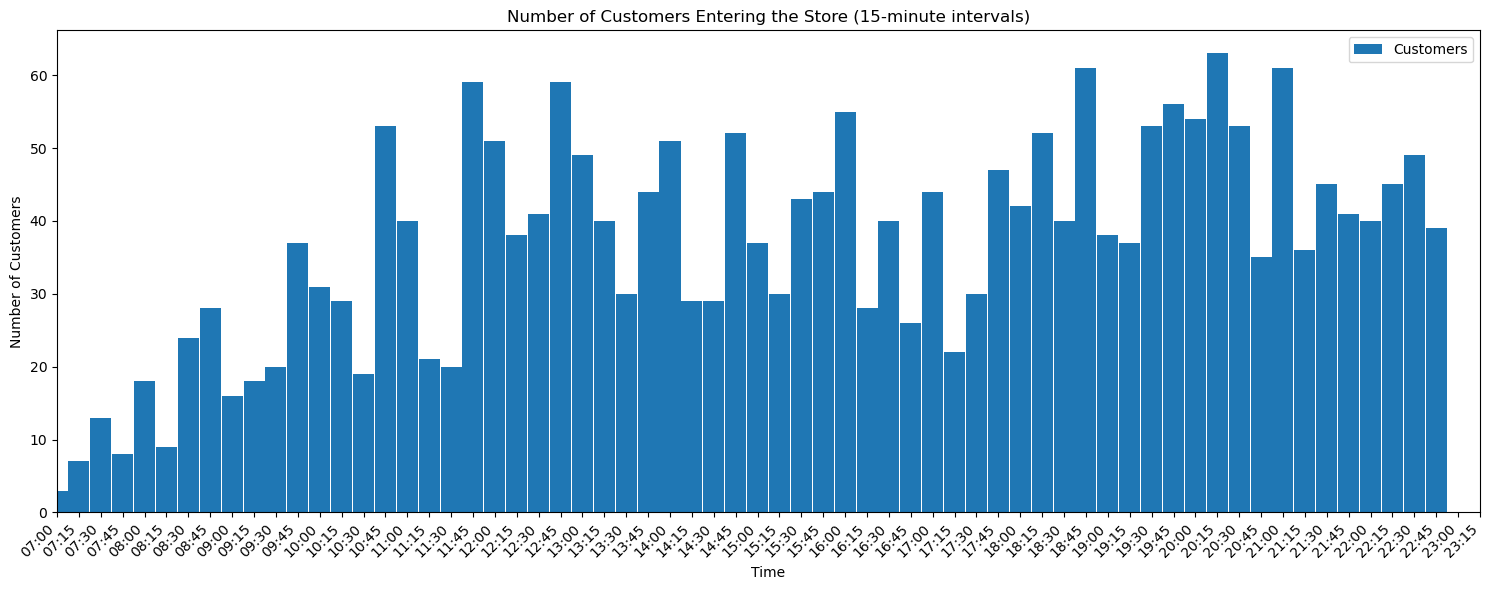

Average number of customers per hour: 148.25


In [2]:

# Calculate the entry time to the store from the purchase time and trip duration
file['entry_time'] = file['purchase_datetime'] - pd.to_timedelta(file['trip_duration_mins'], unit='m')

# Exclude rows with duplicate session IDs
file = file.drop_duplicates(subset='session_id')

# Round the entry_time to the nearest 15 minutes
file['time_bin'] = file['entry_time'].dt.floor('15min')

# Group by the 15-minute bins and sum the group sizes
customer_counts = file.groupby('time_bin')['group_size'].sum()

# Define the range of time bins
full_range = pd.date_range(start=customer_counts.index.min().floor('D') + pd.Timedelta(hours=7),
                           end=customer_counts.index.min().floor('D') + pd.Timedelta(hours=23, minutes=15),
                           freq='15min')

# Reindex the customer counts to include all time bins
customer_counts = customer_counts.reindex(full_range, fill_value=0)

# Plot the results as a bar chart
plt.figure(figsize=(15, 6))
plt.bar(customer_counts.index, customer_counts.values, width=0.01, label='Customers')

# Format x-axis in HH:MM format starting from 7 am ending at 11 15 pm
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 15, 30, 45]))
plt.xlim([pd.Timestamp('2024-02-28 07:00:00'), pd.Timestamp('2024-02-28 23:15:00')])

plt.title('Number of Customers Entering the Store (15-minute intervals)')
plt.xlabel('Time')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate average customers per hour
total_customers = customer_counts.sum()
total_hours = (23-7)
avg_customers_per_hour = total_customers / total_hours

print(f"Average number of customers per hour: {avg_customers_per_hour}")


**Part 2**: Take the average of trip_duration_mins, considering the group size. Calculate the average flow time of a customer in minutes.

In [3]:

# Calculate the total time spent by all customers
total_customer_time = (file['trip_duration_mins'] * file['group_size']).sum()

# Calculate the total number of customers
total_customers = file['group_size'].sum()

# Calculate the average flow time per customer
average_flow_time = total_customer_time / total_customers

print(f"Average flow time per customer: {average_flow_time:.1f} minutes")

Average flow time per customer: 2.1 minutes


**Part 3**: From 7AM till 11PM, draw the inventory build-up diagram. The inventory build-up diagram shows the number of customers in the store at any given time.

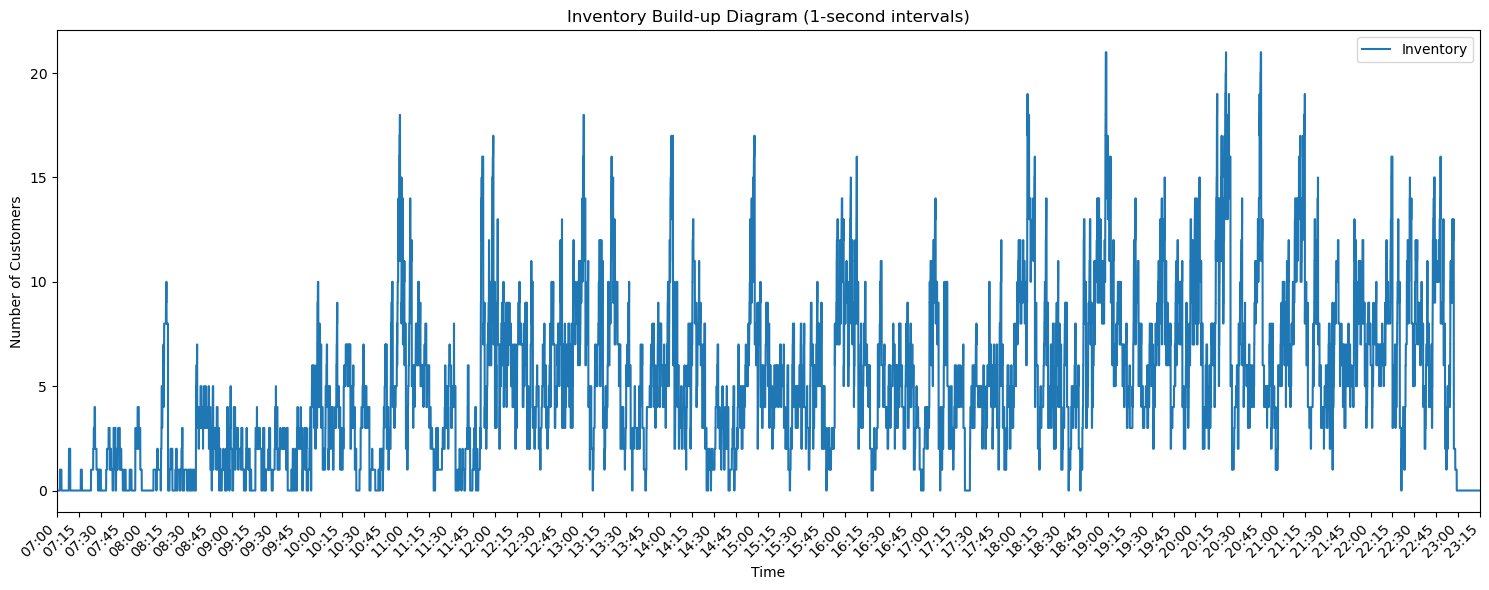

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Initialize inventory count per second
inventory_second = pd.Series(0, index=pd.date_range(start=pd.Timestamp('2024-02-28 07:00:00'), 
                                                    end=pd.Timestamp('2024-02-28 23:15:00'), 
                                                    freq='s'))

# Calculate inventory build-up by adding customers to the inventory and cease adding them at the time of departure
for _, row in file.iterrows():
    entry_time = pd.Timestamp(row['entry_time'])
    exit_time = pd.Timestamp(row['purchase_datetime'])
    
    # Add to inventory for each second between entry and exit
    inventory_second[entry_time:exit_time] += row['group_size']

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(inventory_second.index, inventory_second.values, label='Inventory')

plt.title('Inventory Build-up Diagram (1-second intervals)')
plt.xlabel('Time')
plt.ylabel('Number of Customers')
plt.legend()

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 15, 30, 45]))

# Set x-axis limits
plt.xlim([pd.Timestamp('2024-02-28 07:00:00'), pd.Timestamp('2024-02-28 23:15:00')])

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Note: the inventory build up diagram is done on a second basis and not 15 minute basis to provide a more accurate representation of the inventory build up. Grouping the inventory build up in 15 minute intervals would not provide an accurate representation of the inventory build up as it would not account for the fluctuations in the inventory build up that occur within the 15 minute intervals and assume that the throughput is only at the start of the 15 minute intervals and the flow times are multiples of 15 minute intervals


**Part 4**: Calculate the total time summed up over all customers, i.e., the area under the inventory build-up diagram. Then, calculate the average inventory.


In [5]:
# Calculate the area under the curve using scipy's integrate module. np.trapz or simply using a bar graph of 1 second intervals would work but is not as accurate
from scipy import integrate
seconds_since_start = (inventory_second.index - inventory_second.index[0]).total_seconds()
area_total_time_seconds = integrate.simpson(y=inventory_second.values, x=seconds_since_start)
area_total_time_hours = area_total_time_seconds / 3600

#Calculate Average Inventory
average_inventory = area_total_time_hours / (23-7)

# Print results
print(f"Total area under the curve: {area_total_time_seconds:.2f} customer-seconds")
print(f"Total area under the curve: {area_total_time_hours:.2f} customer-hours")
print(f"Average inventory of customers: {average_inventory:.2f}")

Total area under the curve: 299998.67 customer-seconds
Total area under the curve: 83.33 customer-hours
Average inventory of customers: 5.21


**Part 5**:  Calculate the average inventory using Little's Law and check if it is the same as the average inventory calculated in Part 4.

In [6]:
# Check Little's Law, I = R * T
R_little_law = avg_customers_per_hour  # Already calculated average customers per hour in part 1
T_little_law = average_flow_time  # Already calculated average flow time per customer in part 2

# Calculate L using Little's Law
I_little_law = R_little_law * (T_little_law/60)

print(f"Inventory (L) calculated from Little's Law: {I_little_law:.2f} customers")

# Compare the results
print(f"Comparison: Calculated Average Inventory from graphical method = {average_inventory:.2f} vs Little's Law Inventory = {I_little_law:.2f}")


Inventory (L) calculated from Little's Law: 5.20 customers
Comparison: Calculated Average Inventory from graphical method = 5.21 vs Little's Law Inventory = 5.20


The average inventory calculated from the graphical method is slightly different from the Little's Law calculation using the averages. This could be due to the discrete nature of the data and the area under the curve calculation method used. From the various iterations performed, using scipy.integrate provides the closest estimate.